<a href="https://colab.research.google.com/github/garciafido/cima-goes/blob/master/cima_goes_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Install depencencies

In [0]:
!pip install -q netCDF4
!pip install -q  pyproj
!pip install -q aioftp
!pip install -q aiofiles
# Cartopy
!apt-get -q install libproj-dev proj-data proj-bin
!apt-get -q install libgeos-dev
!pip install -q  cython
!pip install -q  cartopy

# 2 - Install cima.goes library

In [0]:
!pip uninstall -y -q cima.goes
# !pip install --upgrade cima.goes
!pip install -q git+https://github.com/garciafido/cima-goes.git
!pip show cima.goes

# 3 - Example 1: Getting Blob information from GOES repository

In [0]:
import json
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cima.goes.tiles import get_tile_extent
from cima.goes import Band, Product, ProductBand
from cima.goes.utils import timeit
from cima.goes.tiles import Tile, load_tiles, save_tiles, generate_tiles
from cima.goes.storage import FTP, GCS
from cima.goes.data import CLOUD_TOPS_PALETTE, get_lats_lons


CREDENTIALS_FILEPATH = '/OTs/gcs_credentials.json'
TILES_FILEPATH = '/OTs/ir_vis_tiles.json'
FTP_HOST = '<Your Server URL>'
FTP_USER = '<Your User Name>'
FTP_PASSWORD = '<Your Password>'


def get_gcs_credentials(storage):
    data = storage.download_stream(CREDENTIALS_FILEPATH)
    return json.loads(data.decode('UTF-8'))


def get_ftp_storage():
    return FTP(
        host=FTP_HOST,
        user=FTP_USER,
        password=FTP_PASSWORD)


def get_goes_storage():
    # Retrieve GCS credentials from FTP server
    ftp = get_ftp_storage()
    credentials_as_dict = get_gcs_credentials(ftp)

    # Create GOES storage access
    gcs = GCS(credentials_as_dict=credentials_as_dict)
    return gcs


@timeit
def blobs_usage():
    goes_storage = get_goes_storage()

    band_IR = ProductBand(Product.CMIPF, Band.CLEAN_LONGWAVE_WINDOW)

    blobs_IR = goes_storage.one_hour_blobs(2019, 60, 16, band_IR)
    print(f'Bands of {band_IR.band.name}')
    for blob in blobs_IR.blobs:
        print(blob.name)
    print('-' * 101)

    band_VIS = ProductBand(Product.RadF, Band.RED)

    grouped_blobs = goes_storage.grouped_one_hour_blobs(2019, 76, 12, [band_VIS, band_IR])
    print(f'Grouped bands')
    for group in grouped_blobs:
        print(f'{group.start[7:9]}:{group.start[9:11]}')
        for band_blobs in group.blobs:
            print(f'    {band_blobs.band.name}', band_blobs.blobs[0].name)
    print('-' * 101)


blobs_usage()

# 4 - Example 2: Working with netCDF4 Datasets

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v35, 20 July 2016)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 2km at nadir
    orbital_slot: GOES-East
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: Full Disk
    instrument_ID: FM1
    dataset_name: OR_ABI-L2-CMIPF-M3C13_G16_s20190601600312_e20190601611091_c20190601611168.nc
    iso_series_metadata_id: 8c9e8150-3692-11e3-aa6e-0800200c9a66
    title: ABI L2 Cloud and Moisture Imagery
    summary: Single emissive band Cloud and Moisture Imagery Products a

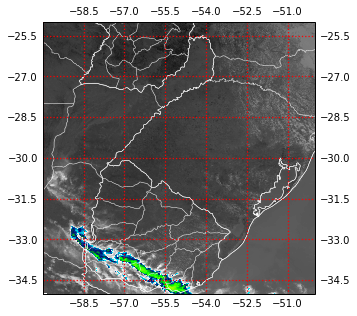

In [4]:
def add_cultural(ax, color='none'):
    states_provinces = cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor=color)

    countries = cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='10m',
        facecolor=color)

    linewidth = 0.50
    ax.coastlines(resolution='10m', color='white', linewidth=linewidth)
    ax.add_feature(countries, edgecolor='white', linewidth=linewidth)
    ax.add_feature(states_provinces, edgecolor='white', linewidth=linewidth)


def add_grid(ax):
    linewidth = 1.25
    ax.gridlines(linewidth=linewidth,
                      linestyle='dotted',
                      color='r',
                      crs=ccrs.PlateCarree(),
                      draw_labels=True)

    
def show_tile(tile, 
              image=None, 
              lats=None, lons=None, 
              cmap=None, vmin=None, vmax=None, overlap=0):
    fig = plt.figure(figsize=(5, 5))
    try:
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        extent = get_tile_extent(tile, trim_excess=overlap)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        add_cultural(ax)
        ax.grid(color='r', linestyle='-', linewidth=2)
        add_grid(ax)
        fig.add_axes(ax, projection=ccrs.PlateCarree())
        if image is not None:
            ax.pcolormesh(lons, lats, image, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.show()
    finally:
        fig.clear()
        plt.close()
    
    
def show_one_band_datasets():
    goes_storage = get_goes_storage()
    product_band = ProductBand(Product.CMIPF, Band.CLEAN_LONGWAVE_WINDOW)
    band_blobs = goes_storage.one_hour_blobs(2019, 60, 16, product_band)
    blob = band_blobs.blobs[0]
    dataset = goes_storage.get_dataset(blob)
    tile = Tile(
        lat_south=-35.0, 
        lat_north=-25.0, 
        lon_west=-60.0, 
        lon_east=-50.0, 
        x_min=3360,
        x_max=3889, 
        y_min=4005, 
        y_max=4456,
    )
    lats, lons = get_lats_lons(dataset, tile)
    data = dataset.variables['CMI'][
        tile.y_min : tile.y_max, 
        tile.x_min : tile.x_max
    ]
    ir_data = data - 273
    show_tile(
        tile, 
        image=ir_data,
        lats=lats, 
        lons=lons, 
        cmap=CLOUD_TOPS_PALETTE, 
        vmin=-90, 
        vmax=50)


@timeit
def get_netcdf_dataset():
    goes_storage = get_goes_storage()
    product_band = ProductBand(Product.CMIPF, Band.CLEAN_LONGWAVE_WINDOW)
    band_blobs = goes_storage.one_hour_blobs(2019, 60, 16, product_band)
    blob = band_blobs.blobs[0]
    dataset = goes_storage.get_dataset(blob)
    print(dataset)

    
get_netcdf_dataset()
show_one_band_datasets()

# 5 - Example 3: Generate Tiles

In [0]:
overlap = 1.5

@timeit
def tiles_generation():
    # Generate and save tiles data
    goes_storage = get_goes_storage()
    bands = [
        ProductBand(Product.CMIPF, Band.CLEAN_LONGWAVE_WINDOW),
#         ProductBand(Product.RadF, Band.RED),
    ]
    return generate_tiles(
        goes_storage,
        bands,
        lat_south=-45,
        lat_north=-20,
        lon_west=-75,
        lon_east=-45,
        lat_step=5,
        lon_step=5,
        lon_overlap=overlap,
        lat_overlap=overlap,
    )
    tiles = generate()
    print('Generated: ', tiles)

    # Get FTP storage
    ftp = get_ftp_storage()
    save_tiles(ftp, TILES_FILEPATH, tiles)
    

def show_tile(tile):
    fig = plt.figure(figsize=(5, 5))
    try:
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        extent = get_tile_extent(tile, trim_excess=overlap)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        add_cultural(ax, color='gray')
        ax.grid(color='r', linestyle='-', linewidth=2)
        add_grid(ax)
        fig.add_axes(ax, projection=ccrs.PlateCarree())
        plt.show()
    finally:
        fig.clear()
        plt.close()
    
    
def retrieve_tiles_information():
    # Retrieve the saved tiles data
    ftp = get_ftp_storage()
    tiles = load_tiles(ftp, TILES_FILEPATH)
    for _, tile in tiles[(Product.RadF, Band.RED)].items():
        show_tile(tile)


tiles_generation()
retrieve_tiles_information()
